In [2]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

In [11]:
RefPath = '/srv/home/chenyu/DEbackup/112518/C1/'
RefName = 'S0'
BeamLevel = 0
rx = 150
ry = 150

for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        BeamLevel = BeamLevel + np.sum(frame)

BeamLevel = BeamLevel / rx / ry

In [17]:
path = '/srv/home/chenyu/DEbackup/112518/S14/'
ref = '/srv/home/chenyu/DEbackup/112518/BlankCOM.npy'   # path for center detected on empty scan
# generate datacube to save 4Ddata
PACBED = np.zeros([512,512])
AnnularInt = np.zeros([150,150,250])
ref = np.load(ref)

# load raw dataset
for irow in range(datacube.shape[0]):
    print('Now working on row ' + str(irow))
        
    for icol in range(datacube.shape[1]):
        
        filenum = irow*150+icol+1
        frame = np.load(path+'npy/S14_'+format(filenum,'05')+'.npy')
        frame = frame/BeamLevel
        
        cx = ref[ix,iy,0]
        cy = ref[ix,iy,1]

        radius_limit = 250
        pad_size = int(np.ceil(radius_limit - min([cx,cy,512-cx,512-cy])))

        frame_padded = np.pad(frame,((pad_size, pad_size), (pad_size, pad_size)),'constant',constant_values=(0,0))
        frame_polar = convert (frame_padded, [512+pad_size*2,512+pad_size*2], [cy+pad_size,cx+pad_size])
        frame_annular = np.zeros(radius_limit)

        for dist in range(radius_limit):
            frame_annular[dist] = np.average(frame_polar[dist,~isnan(frame_polar[dist,:])])


# AnnularInt_2.npy uses center of PACBED as cx and cy, instead of using COM center from blank scan
np.save(path + 'AnnularInt_origsize_interpolation.npy', AnnularInt)

Now working on row 0
Now working on row 1
Now working on row 2
Now working on row 3
Now working on row 4
Now working on row 5
Now working on row 6
Now working on row 7
Now working on row 8
Now working on row 9
Now working on row 10
Now working on row 11
Now working on row 12
Now working on row 13
Now working on row 14
Now working on row 15
Now working on row 16
Now working on row 17
Now working on row 18
Now working on row 19
Now working on row 20
Now working on row 21
Now working on row 22
Now working on row 23
Now working on row 24
Now working on row 25
Now working on row 26
Now working on row 27
Now working on row 28
Now working on row 29
Now working on row 30
Now working on row 31
Now working on row 32
Now working on row 33
Now working on row 34
Now working on row 35
Now working on row 36
Now working on row 37
Now working on row 38
Now working on row 39
Now working on row 40
Now working on row 41
Now working on row 42
Now working on row 43
Now working on row 44
Now working on row 4

In [14]:
from scipy.interpolate import griddata
from numpy import exp, abs,angle
from scipy.interpolate import RectBivariateSpline

def convert (img, size, center, correction=False, plot=False):
    '''
    :param img: a 2-d array for the image to convert to polar coordinates
    :param center: x,y coordinates for the center of the image
    :param correction: the circular correction
    :param size: [x,y] describing the pixel dimensions of the photo
    :return: polar_img r vs. theta
    '''
    phase_width = 360
    r_inital = 0
    r_final =250
    final_theta, final_r = create_grid(np.linspace(-1*np.pi,np.pi,phase_width),np.arange(0,r_final,1))
#     initial_x, initial_y = create_grid(range(1,size[0]+1),range(1,size[1]+1))
#     initial_y, initial_x = range(1, 513), range(1, 513)
    initial_y, initial_x = range(1, size[0]+1), range(1, size[1]+1)
    final_x, final_y = polar_list_to_cartesian(final_r,final_theta,center)
    
    #initial_theta, initial_r = cartesian_list_to_polar(initial_x,initial_y,center)
#     inten = np.reshape(img,size[0]*size[1])
#     polar_img = griddata((initial_x,initial_y),inten,(final_x,final_y), method='linear')
    inten = img
    spline = RectBivariateSpline(initial_x, initial_y,inten,kx=1,ky=1)
    polar_img = spline.ev(final_x,final_y)
    
    polar_img = np.reshape(polar_img, [r_final, phase_width])
    if plot:
        plt.imshow(polar_img, extent=(0, 6.293, 0, 6))
        plt.show()
    return polar_img

def cartesian_to_polar(x,y,center):
    '''
    A function that converts the x,y coordinates to polar ones.
    -Does not do the circular correction
    '''
    corrected_x= x-center[0]
    corrected_y= y-center[1]
    theta = np.arctan2(corrected_y,corrected_x)
    r = np.sqrt(corrected_x**2+ corrected_y**2)
    return theta,r

def polar_to_cartesian(r, theta, center):
    x = center[0]+r*np.cos(theta)
    y = center[1] +r*np.sin(theta)
    return x,y

def cartesian_list_to_polar(x_list,y_list,center):
    theta_list = []
    r_list = []
    for x,y in zip(x_list,y_list):
        t,r =cartesian_to_polar(x,y,center)
        theta_list.append(t)
        r_list.append(r)
    return theta_list, r_list

def polar_list_to_cartesian(r_list,theta_list, center):
    x_list = []
    y_list = []
    for r, t in zip(r_list,theta_list):
        x,y = polar_to_cartesian(r,t,center)
        x_list.append(x)
        y_list.append(y)
    return x_list,y_list

def create_grid (dimension1,dimension2):
    '''
    Takes data from array of points turns it into a grid of coordinates
    '''
    dim1,dim2 =np.meshgrid(dimension1,dimension2)
    size = len(dimension1)*len(dimension2)
    a,b = np.reshape(dim1,size),np.reshape(dim2,size)
    return a,b

def circular_grid_data(intial_r, initial_theta, intensity, final_r,final_theta):
    #interpolating the radi and theta values from the cartesian points and mapping the intesities to evenly spaced
    # points in r an theta through linear interpolation... possibly some other interpolation....
    #for r,t in zip(final_r,final_theta):

    return


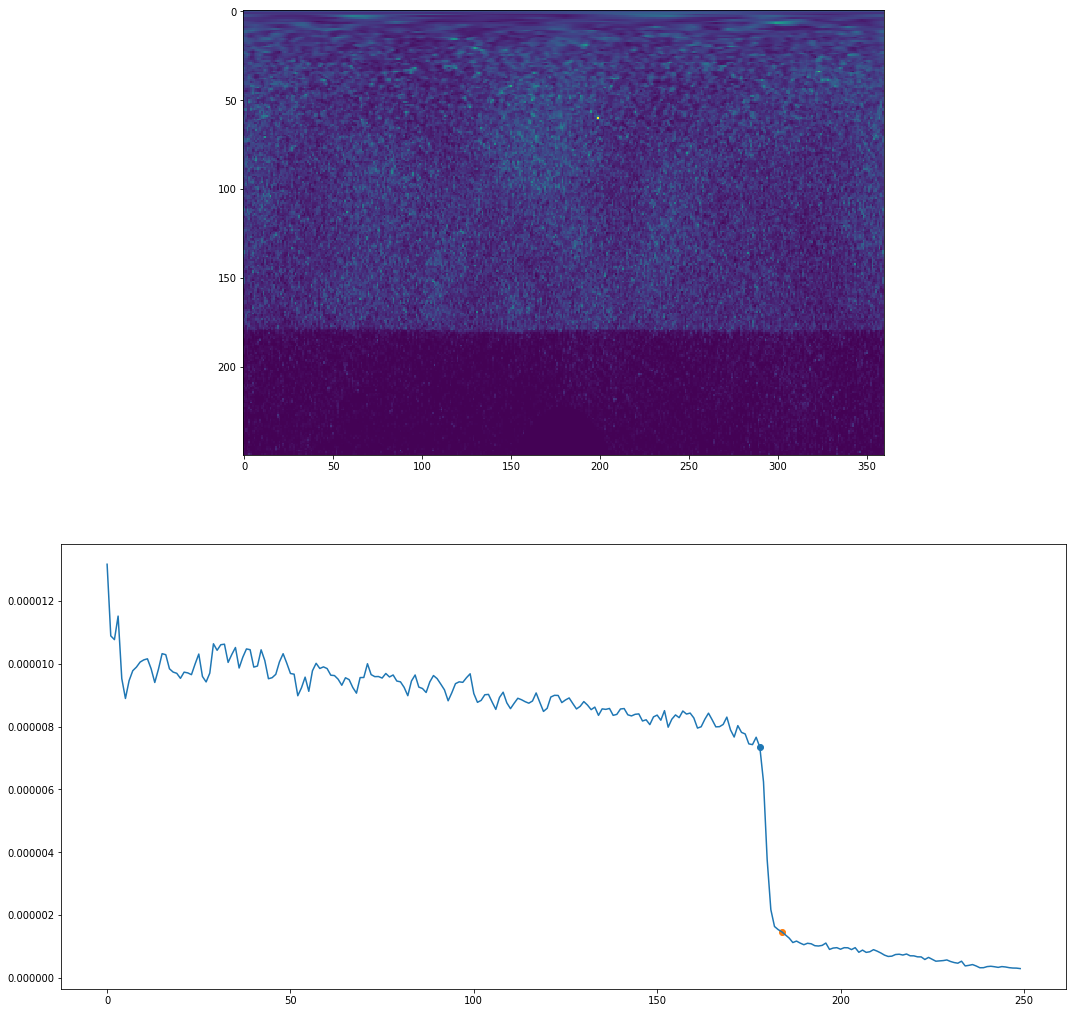

In [15]:
path = '/srv/home/chenyu/DEbackup/112518/S15/'
ref = '/srv/home/chenyu/DEbackup/112518/BlankCOM.npy'   # path for center detected on empty scan
# generate datacube to save 4Ddata
datacube = np.zeros([150,150,512,512])
PACBED = np.zeros([512,512])
BeamLevel = 21455562.93284358

# load raw dataset

ix = 20
iy = 20

ref = np.load(ref)

filenum = ix*150+iy+1
frame = np.load(path+'npy/S15_'+format(filenum,'05')+'.npy')
frame = frame/BeamLevel
# plt.imshow(frame_resize)
cx = ref[ix,iy,0]
cy = ref[ix,iy,1]

radius_limit = 250
pad_size = int(np.ceil(radius_limit - min([cx,cy,512-cx,512-cy])))

frame_padded = np.pad(frame,((pad_size, pad_size), (pad_size, pad_size)),'constant',constant_values=(0,0))
frame_polar = convert (frame_padded, [512+pad_size*2,512+pad_size*2], [cy+pad_size,cx+pad_size])
frame_annular = np.zeros(radius_limit)

for dist in range(radius_limit):
    frame_annular[dist] = np.average(frame_polar[dist,~isnan(frame_polar[dist,:])])

fig, ax = subplots(2,1,figsize=(18, 18))
ax[0].imshow(frame_polar)
ax[1].plot(frame_annular)
ax[1].scatter(178,frame_annular[178])
ax[1].scatter(184,frame_annular[184])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


261.6 290.2


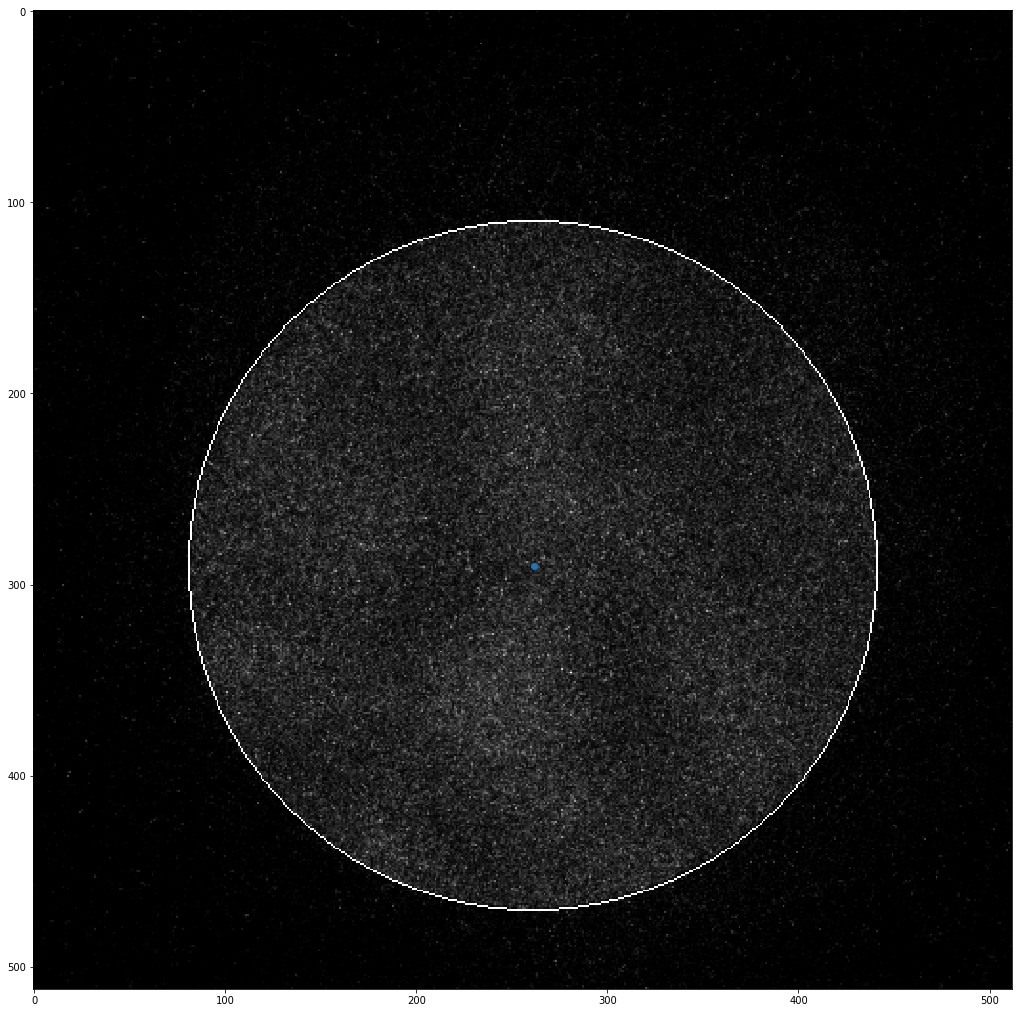

In [9]:
from skimage.draw import circle_perimeter
from skimage import data, color

fig, ax = subplots(figsize=(18, 18))
frame_norm = frame/np.amax(frame)
frame_norm = color.gray2rgb(frame_norm)
circy, circx = circle_perimeter(int(cy),int(cx),180)
frame_norm[circy, circx] = (220, 20, 20)
ax.imshow(frame_norm)
ax.scatter(cx,cy)
print(cx,cy)

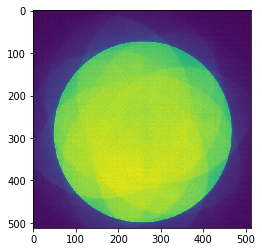

In [10]:
temp = np.load('/srv/home/chenyu/DEbackup/110818/S6/PACBED.npy')
plt.imshow(temp)